## 1. Data source: PPG-DaLiA (Zenodo benchmark: PPGDalia)

**Dataset:** *PPGDalia* (time-series regression benchmark derived from the public **PPG-DaLiA** dataset)

- **Zenodo record (download + description):**  
    - https://doi.org/10.5281/zenodo.3902728  
- **Original dataset page (background / context):**  
    - https://archive.ics.uci.edu/ml/datasets/PPG-DaLiA  
- **Local path (expected):** download + unzip into `./data/PPGDalia/`    
- **License:** Creative Commons Attribution 4.0 International (**CC BY 4.0**)

PPG-DaLiA is a public wearable physiology dataset for **wrist PPG-based heart rate estimation under motion**. It includes recordings from **15 subjects** performing a range of real-life activities, with **ECG-derived heart rate** as ground truth. The Zenodo **PPGDalia** variant used here is a **benchmark-ready export**: it is **pre-segmented into windows** and distributed in a standardized time-series regression format (the `.ts` format). Signals in this benchmark version are provided as ML-ready time series (segmented and typically normalized/standardized for benchmarking), and the `.ts` files do not preserve physical sensor units.

**File format (Zenodo benchmark):** two `.ts` files with a predefined split:  
- `PPGDalia_TRAIN.ts`  
- `PPGDalia_TEST.ts`  

Each sample is **one window** (one multivariate time series) with:  
- **4 dimensions**: `dim_0`, `dim_1`, `dim_2`, `dim_3`  
- **1 target label** per window: **heart rate (bpm)**  

**Channel meaning (from dataset description):**  
- `dim_0`: wrist **PPG**  
- `dim_1–dim_3`: wrist **accelerometer (x, y, z)**  

*(The `.ts` header does not explicitly name channels; we treat the 4 dimensions as 1×PPG + 3×ACC as described.)*

**What we use in this notebook:** the provided **TRAIN/TEST split**, using **wrist PPG + wrist ACC** as inputs and **HR (bpm)** as the regression target. We keep preprocessing minimal and focus on **motion-aware / reliability features** and **robust evaluation**.


## 2. Load data (TRAIN/TEST) + quick inspection

We load the pre-defined `PPGDalia_TRAIN.ts` / `PPGDalia_TEST.ts` files from `./data/PPGDalia/`, convert the HR labels to numeric, and run a few quick sanity checks (shapes, value ranges, and a single-sample peek).


In [1]:
from pathlib import Path
import numpy as np
from sktime.datasets import load_from_tsfile

DATA_DIR = Path("../data/PPGDalia")
train_path = DATA_DIR / "PPGDalia_TRAIN.ts"
test_path  = DATA_DIR / "PPGDalia_TEST.ts"

assert train_path.exists(), f"Missing: {train_path}"
assert test_path.exists(), f"Missing: {test_path}"

# Load (default return type is a DataFrame of nested series)
X_train, y_train = load_from_tsfile(train_path)
X_test,  y_test  = load_from_tsfile(test_path)

# Labels sometimes load as strings; convert to float
y_train = np.asarray(y_train, dtype=float)
y_test  = np.asarray(y_test, dtype=float)

print("Loaded:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_test : {X_test.shape}  | y_test : {y_test.shape}")

# Basic sanity checks
n_channels = X_train.shape[1]
print("\nChannels (dims):", n_channels)
print("HR (bpm) train: min/median/max =",
      f"{y_train.min():.1f} / {np.median(y_train):.1f} / {y_train.max():.1f}")
print("HR (bpm) test : min/median/max =",
      f"{y_test.min():.1f} / {np.median(y_test):.1f} / {y_test.max():.1f}")

# Peek at a single sample: length per channel
i = 0
lengths = [len(X_train.iloc[i, d]) for d in range(n_channels)]
print(f"\nExample window index {i} (train): lengths per dim =", lengths)

# Show a tiny preview (first few y values)
print("\nFirst 5 HR labels (train):", y_train[:5])


Loaded:
  X_train: (43215, 4) | y_train: (43215,)
  X_test : (21482, 4)  | y_test : (21482,)

Channels (dims): 4
HR (bpm) train: min/median/max = 41.9 / 85.8 / 187.0
HR (bpm) test : min/median/max = 41.7 / 83.8 / 171.1

Example window index 0 (train): lengths per dim = [512, 256, 256, 256]

First 5 HR labels (train): [49.61136908 50.32399248 52.70833578 55.64079409 57.65840574]


## 3. Signal sanity-check and channel naming

We visually inspect a couple of example windows to confirm which channel corresponds to PPG versus motion.

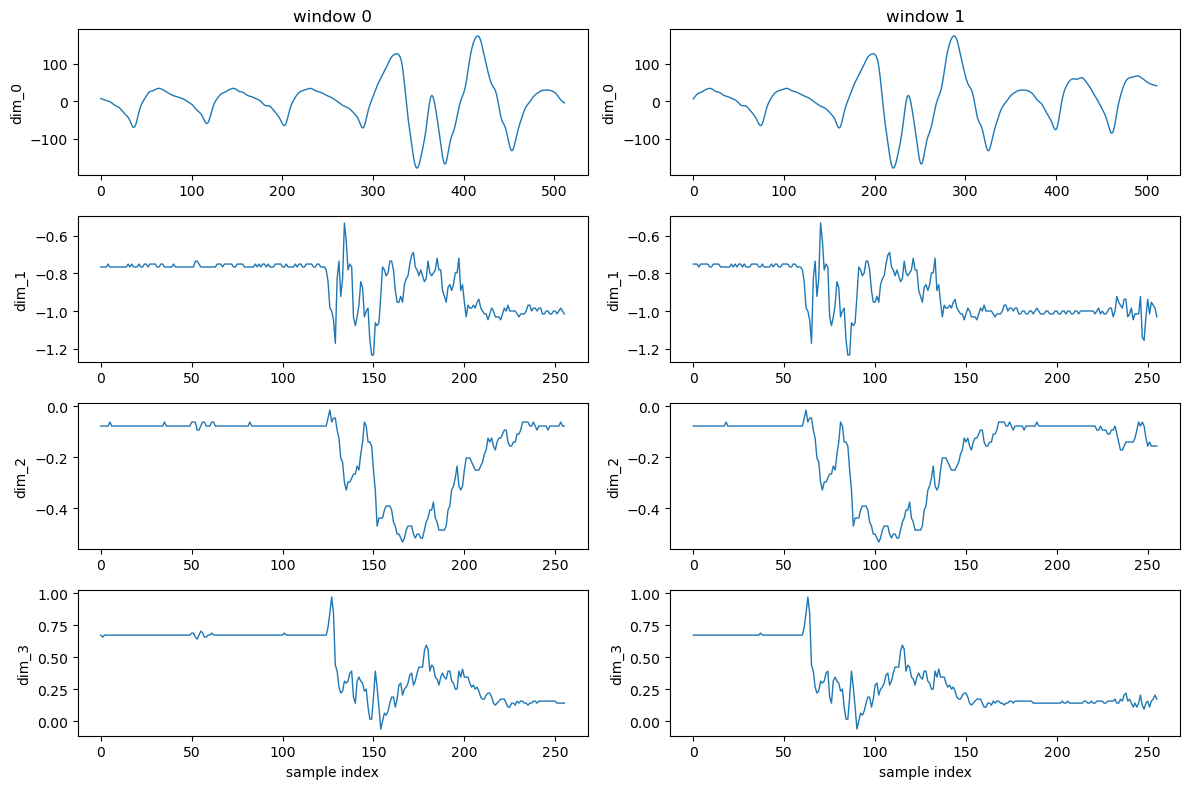

In [2]:
import matplotlib.pyplot as plt

# example windows
idxs = [0, 1]
fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=False, sharey=False)

for col, i in enumerate(idxs):
    for d in range(4):
        x = X_train.iloc[i, d].to_numpy(dtype=float)
        axes[d, col].plot(x, lw=1)
        axes[d, col].set_ylabel(f"dim_{d}")
        if d == 0:
            axes[d, col].set_title(f"window {i}")

axes[-1, 0].set_xlabel("sample index")
axes[-1, 1].set_xlabel("sample index")
plt.tight_layout()
plt.show()

- The quasi-periodic waveform of dim_0 confirms it to be the `ppg` channel.  
- The shorter length, step changes and bursts observed at dim_1 to dim_3 confirms them to be our `acc_x`, `acc_y`, `acc_z` channels. 

In [3]:
# Renaming
CHANNELS = ["ppg", "acc_x", "acc_y", "acc_z"]

X_train = X_train.copy()
X_test = X_test.copy()

X_train.columns = CHANNELS
X_test.columns = CHANNELS

print("Info X_train:\n")
print(X_train.info())
print("\nInfo X_test:\n")
print(X_test.info())

Info X_train:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43215 entries, 0 to 43214
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ppg     43215 non-null  object
 1   acc_x   43215 non-null  object
 2   acc_y   43215 non-null  object
 3   acc_z   43215 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB
None

Info X_test:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21482 entries, 0 to 21481
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ppg     21482 non-null  object
 1   acc_x   21482 non-null  object
 2   acc_y   21482 non-null  object
 3   acc_z   21482 non-null  object
dtypes: object(4)
memory usage: 671.4+ KB
None


## 4. Feature extraction

We convert each window into a **small, interpretable feature vector** that captures two core concepts relevant to on-wrist heart rate estimation: **motion intensity** and **PPG periodicity**.

**Motion intensity:**

We use the accelerometer as a **proxy for motion artefacts** affecting the PPG signal.  

For each window, we compute:  
- the **acceleration magnitude**: `|acc| = sqrt(acc_x² + acc_y² + acc_z²)`  
- the **mean** of `|acc|`  
- the **standard deviation** of `|acc|`  

These statistics are widely used and sufficient to summarize overall motion level and variability within a window.

**PPG periodicity:**  

We use a simple **frequency-domain proxy** to quantify how “heart-rate-like” the PPG waveform looks.

We focus on a **physiologically plausible heart-rate band** of **0.7–3.5 Hz** (≈ **42–210 bpm**), which is commonly adopted in prior work on PPG-based HR estimation, including studies using the **PPG-DaLiA dataset**.[^deepppg]

For each window, we compute:  
- the **dominant frequency** (peak frequency) of the PPG power spectrum within **0.7–3.5 Hz**  
- the **peak power ratio**: power at that dominant frequency divided by total power in the same band  

Intuition: a clean PPG window tends to show a clear spectral peak in this band, while motion-corrupted windows often exhibit weaker or less stable periodic structure.

[^deepppg]: Reiss, A., Indlekofer, I., Schmidt, P., & Van Laerhoven, K. (2019).  
*Deep PPG: Large-Scale Heart Rate Estimation with Convolutional Neural Networks.* **Sensors**, 19(14), 3079.  
https://doi.org/10.3390/s19143079


In [4]:
import pandas as pd
from scipy import signal

# Sampling rates (consistent with the original PPG-DaLiA setup;
# also matches our earlier window lengths check: [512, 256, 256, 256]; 
# 512 PPG samples / 64 Hz = 8s, 256 ACC samples / 32 Hz = 8s)
FS_PPG = 64.0
FS_ACC = 32.0

# "Plausible" HR band (in Hz): 0.7–3.5 Hz ≈ 42–210 bpm
HR_BAND_HZ = (0.7, 3.5)


def acc_magnitude(acc_x, acc_y, acc_z):
    """Acceleration magnitude per sample."""
    return np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)


def ppg_periodicity_features(ppg, fs=FS_PPG, band_hz=HR_BAND_HZ):
    """
    Frequency-domain proxies for how 'heart-rate-like' a PPG window is.

    Notes (standard signal-processing steps):
    - We remove the DC offset (subtract the mean) so very-low-frequency baseline/wander
      does not dominate the spectrum.
    - We estimate a one-sided PSD via scipy.signal.periodogram. For real-valued signals
      (like PPG), the FFT spectrum is symmetric, so the one-sided PSD keeps only
      non-negative frequencies, which is standard and sufficient here.

    Returns:
      - dom_freq_hz: dominant frequency (Hz) within the HR band
      - peak_power_ratio: peak PSD value / total PSD power within the HR band
    """
    ppg = np.asarray(ppg, dtype=float)
    ppg = ppg - np.mean(ppg)  # remove DC offset (baseline)

    # PSD estimate (one-sided for real signals; returns freq >= 0)
    freqs, psd = signal.periodogram(ppg, fs=fs)

    f_lo, f_hi = band_hz
    band_mask = (freqs >= f_lo) & (freqs <= f_hi)
    if not np.any(band_mask):
        return np.nan, np.nan

    band_freqs = freqs[band_mask]
    band_psd = psd[band_mask]

    peak_idx = int(np.argmax(band_psd))
    dom_freq_hz = float(band_freqs[peak_idx])

    band_power = float(np.sum(band_psd))
    peak_power = float(band_psd[peak_idx])
    peak_power_ratio = peak_power / band_power if band_power > 0 else np.nan

    return dom_freq_hz, peak_power_ratio


def extract_features(X):
    """
    X: sktime nested DataFrame with columns ['ppg','acc_x','acc_y','acc_z'].
    Returns: pandas DataFrame of features (one row per window).
    """
    rows = []
    for i in range(len(X)):
        ppg = X.loc[i, "ppg"].to_numpy(dtype=float)

        ax = X.loc[i, "acc_x"].to_numpy(dtype=float)
        ay = X.loc[i, "acc_y"].to_numpy(dtype=float)
        az = X.loc[i, "acc_z"].to_numpy(dtype=float)
        amag = acc_magnitude(ax, ay, az)

        # Motion intensity proxies
        acc_mag_mean = float(np.mean(amag))
        acc_mag_std = float(np.std(amag))

        # PPG periodicity proxies
        dom_f, peak_ratio = ppg_periodicity_features(ppg, fs=FS_PPG, band_hz=HR_BAND_HZ)

        rows.append({
            "acc_mag_mean": acc_mag_mean,
            "acc_mag_std": acc_mag_std,
            "ppg_dom_freq_hz": dom_f,
            "ppg_peak_power_ratio": peak_ratio,
        })

    return pd.DataFrame(rows)


# Compute feature tables
X_feat_train = extract_features(X_train.reset_index(drop=True))
X_feat_test  = extract_features(X_test.reset_index(drop=True))

display(X_feat_train.head())
print("Feature matrix shapes (train - test):", X_feat_train.shape, X_feat_test.shape)

,acc_mag_mean,acc_mag_std,ppg_dom_freq_hz,ppg_peak_power_ratio
0,1.018543,0.071625,0.750,0.574718
1,1.018886,0.073404,0.750,0.285373
2,1.016308,0.069871,0.875,0.416325
3,1.018729,0.071553,0.875,0.686951
4,1.020364,0.126706,0.875,0.483571


Feature matrix shapes (train - test): (43215, 4) (21482, 4)


### 4.1. PPG periodicity under low vs high motion

We visualize two example windows—one with **low motion** and one with **high motion**.
For each example, we show:  
- the **time-domain PPG**, and  
- the **band-limited, band-normalized power spectrum** in the physiological HR band (**0.7–3.5 Hz**), with the **dominant frequency** highlighted.  

The spectrum is **normalized within the HR band** and **cropped to that band** to visualize cardiac periodicity under motion.

Low-motion example idx : 4738 | acc_mag_std: 0.0
High-motion example idx: 5706 | acc_mag_std: 0.7733447856251788


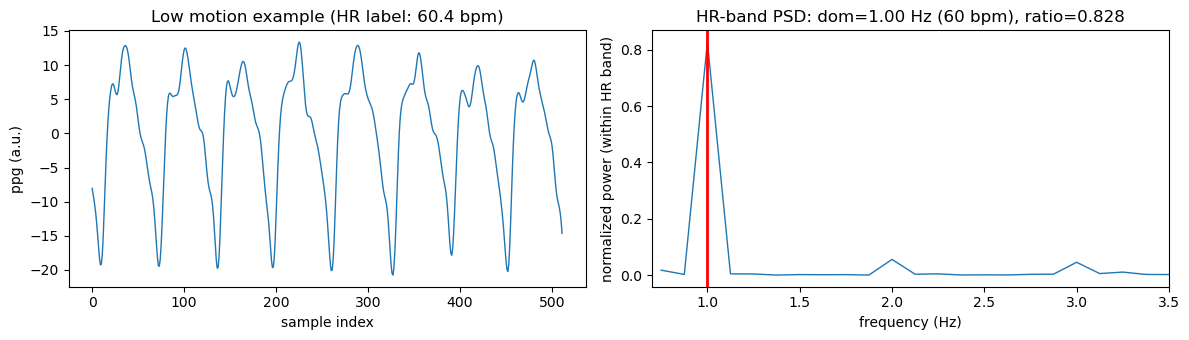

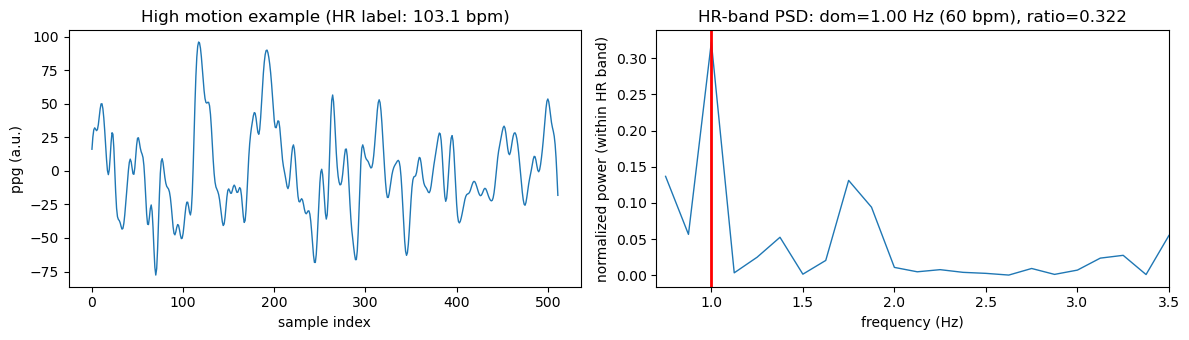

In [5]:
# examples: one low-motion and one high-motion (using acc_mag_std)
order = np.argsort(X_feat_train["acc_mag_std"].to_numpy())
low_i = int(order[0])
high_i = int(order[-1])

print("Low-motion example idx :", low_i,  "| acc_mag_std:", X_feat_train.loc[low_i, "acc_mag_std"])
print("High-motion example idx:", high_i, "| acc_mag_std:", X_feat_train.loc[high_i, "acc_mag_std"])

def show_window_and_psd(i, label):
    ppg = X_train.loc[i, "ppg"].to_numpy(dtype=float)
    ppg = ppg - np.mean(ppg)      # remove DC offset (baseline)

    # One-sided PSD
    freqs, psd = signal.periodogram(ppg, fs=FS_PPG)

    # HR band
    f_lo, f_hi = HR_BAND_HZ
    band_mask = (freqs >= f_lo) & (freqs <= f_hi)

    # Normalize PSD within the HR band
    band_power = np.sum(psd[band_mask])
    psd_norm = psd / band_power if band_power > 0 else psd

    # Dominant frequency (from features already computed)
    dom_f = X_feat_train.loc[i, "ppg_dom_freq_hz"]
    ratio = X_feat_train.loc[i, "ppg_peak_power_ratio"]
    dom_bpm = 60.0 * dom_f if np.isfinite(dom_f) else np.nan

    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

    axes[0].plot(ppg, lw=1)
    axes[0].set_title(f"{label} (HR label: {y_train[i]:.1f} bpm)")
    axes[0].set_xlabel("sample index")
    axes[0].set_ylabel("ppg (a.u.)")

    # Band-limited PSD
    axes[1].plot(freqs[band_mask], psd_norm[band_mask], lw=1)
    axes[1].set_xlim(f_lo, f_hi)
    if np.isfinite(dom_f):
        axes[1].axvline(dom_f, color="red", lw=2)
        axes[1].set_title(f"HR-band PSD: dom={dom_f:.2f} Hz ({dom_bpm:.0f} bpm), ratio={ratio:.3f}")
    else:
        axes[1].set_title("HR-band PSD (dominant freq not found)")
    axes[1].set_xlabel("frequency (Hz)")
    axes[1].set_ylabel("normalized power (within HR band)")

    plt.tight_layout()
    plt.show()


show_window_and_psd(low_i, "Low motion example")
show_window_and_psd(high_i, "High motion example")

### 4.2. Motion vs PPG periodicity (binned view)

We summarize the relationship between **motion intensity** and **PPG periodicity** by binning windows according to accelerometer-based motion and examining the distribution of the **PPG peak power ratio** within each bin.

This view highlights a key wearable intuition: as motion increases, **high periodicity becomes less common**, even though low periodicity can occur at all motion levels.


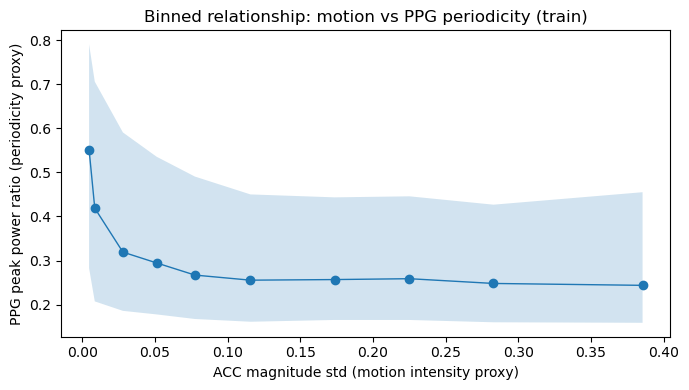

In [6]:
df = X_feat_train.copy()

# Bin motion intensity into quantiles (equal-count bins)
n_bins = 10
df["motion_bin"] = pd.qcut(df["acc_mag_std"], q=n_bins, duplicates="drop")

# Summarize periodicity in each bin
summary = (
    df.groupby("motion_bin", observed=False)["ppg_peak_power_ratio"]
      .agg(
          motion_std_median=lambda s: float(np.median(df.loc[s.index, "acc_mag_std"])),
          p10=lambda s: float(np.quantile(s, 0.10)),
          p50="median",
          p90=lambda s: float(np.quantile(s, 0.90)),
      )
      .reset_index(drop=True)
      .sort_values("motion_std_median")
)

# Plot: median and a 10–90% band vs motion level
plt.figure(figsize=(7, 4))
plt.plot(summary["motion_std_median"], summary["p50"], marker="o", lw=1, label="median")
plt.fill_between(summary["motion_std_median"], summary["p10"], summary["p90"], alpha=0.2, label="10–90%")

plt.xlabel("ACC magnitude std (motion intensity proxy)")
plt.ylabel("PPG peak power ratio (periodicity proxy)")
plt.title("Binned relationship: motion vs PPG periodicity (train)")
plt.tight_layout()
plt.show()


## 5. Modeling

We train and compare a small set of **standard regression models** using the extracted features.

The goal is to establish **clean, well-understood baselines** rather than to optimize performance.  
All models are trained on the predefined training split, with samples **shuffled once before fitting** to avoid any ordering effects.

We **do not perform cross-validation** (e.g. k-fold or group-wise CV) or inner hyperparameter tuning:  
- the dataset provides a **fixed train/test split**, and  
- **subject identifiers are not available** in this benchmark format, making group-aware validation infeasible.  

**Models:**  
- **Ridge Regression**: a stable linear baseline suitable for correlated features.  
- **Support Vector Regression (SVR)**: a commonly used nonlinear regressor in biosignal tasks.  
- **HistGradientBoostingRegressor (HGBR)**: a strong tree-based nonlinear model with sensible defaults.  

**Metrics (evaluated on the test split):**  
- **MAE (bpm)** and **RMSE (bpm)** as core regression error metrics.  
- A simple **within-tolerance accuracy** to support intuition (e.g., % predictions within ±5 bpm and ±10 bpm of the true HR).  


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from tqdm.auto import tqdm
import time

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# Data
Xtr = X_feat_train.copy()
Xte = X_feat_test.copy()
ytr = y_train.copy()
yte = y_test.copy()

# Shuffle TRAIN once
perm = rng.permutation(len(Xtr))
Xtr = Xtr.iloc[perm].reset_index(drop=True)
ytr = ytr[perm]

# Models
models = {
    "Ridge": Pipeline([("scaler", StandardScaler()),
                       ("model", Ridge(random_state=RANDOM_STATE))]),
    "SVR": Pipeline([("scaler", StandardScaler()),
                     ("model", SVR())]),
    "HGBR": HistGradientBoostingRegressor(random_state=RANDOM_STATE),
}

fitted_models = {}
y_pred_test = {}
rows = []

for name, model in models.items():

    with tqdm(total=1, desc=f"Model: {name}", leave=True) as pbar:
        t0 = time.perf_counter()

        # Train
        model.fit(Xtr, ytr)
        # Test predictions
        preds = model.predict(Xte)

        elapsed = time.perf_counter() - t0
        pbar.set_postfix_str(f"{elapsed:.1f}s")
        pbar.update(1)
    
    fitted_models[name] = model
    y_pred_test[name] = preds

    # Metrics (test)
    mae = mean_absolute_error(yte, preds)
    rmse = root_mean_squared_error(yte, preds)
    within_5 = 100.0 * np.mean(np.abs(preds - yte) <= 5.0)
    within_10 = 100.0 * np.mean(np.abs(preds - yte) <= 10.0)

    rows.append({
        "model": name,
        "MAE (bpm)": mae,
        "RMSE (bpm)": rmse,
        "Accuracy within ±5 bpm (%)": within_5,
        "Accuracy within ±10 bpm (%)": within_10,
        "Train+test time (s)": elapsed,
    })

# Ranked results table
results_df = (
    pd.DataFrame(rows)
      .sort_values("MAE (bpm)")
      .reset_index(drop=True)
)

# Predictions table for next section
pred_df = pd.DataFrame({"y_true": yte})
for name, preds in y_pred_test.items():
    pred_df[f"y_pred_{name}"] = preds

display(results_df)


Model: HGBR: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s, 0.2s]


,model,MAE (bpm),RMSE (bpm),Accuracy within ±5 bpm (%),Accuracy within ±10 bpm (%),Train+test time (s)
0,SVR,8.515425,12.951099,52.294945,70.794153,66.407979
1,HGBR,9.199082,13.783455,49.213295,68.839028,0.182878
2,Ridge,12.745528,16.196043,23.089098,46.578531,0.003872


## 6. Results and error analysis

Across all metrics, **SVR** achieves the best overall performance on this benchmark, with the lowest **MAE** and **RMSE**, and the highest **within-tolerance accuracy**. This suggests that moderate nonlinear modeling is beneficial for HR estimation from compact, motion-aware features.

**HGBR** performs comparably but slightly worse across metrics, indicating that tree-based nonlinearities do not offer a clear advantage over SVR in this low-dimensional feature setting. In contrast, **Ridge regression** underperforms substantially, highlighting the limitations of a purely linear model for this task.

In terms of efficiency, training time varies widely: Ridge and HGBR train almost instantly, while SVR is significantly more expensive. This trade-off between accuracy and compute will be important when considering deployment or scaling.


### 6.1 True vs predicted heart rate


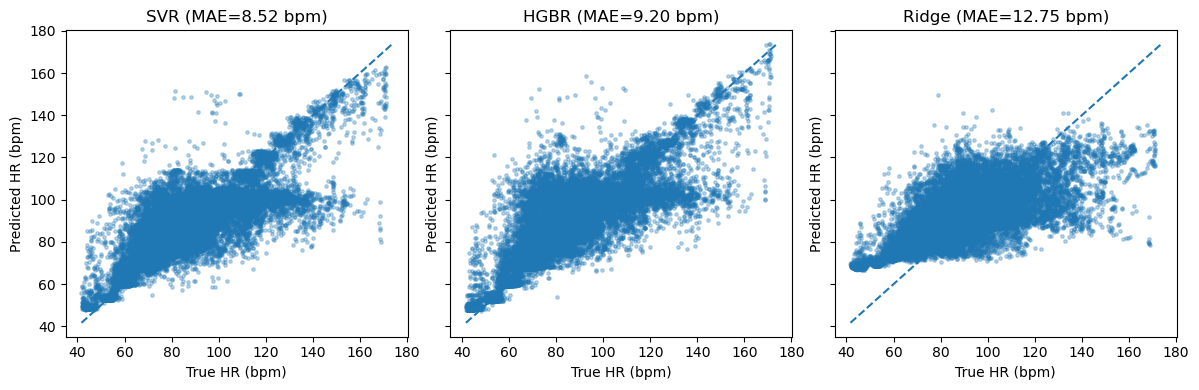

In [17]:
models_order = ["SVR", "HGBR", "Ridge"]  # best -> worst

# Build a quick lookup for MAE from results_df
mae_map = dict(zip(results_df["model"], results_df["MAE (bpm)"]))

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

y_min = min(pred_df["y_true"].min(),
            *(pred_df[f"y_pred_{m}"].min() for m in models_order))
y_max = max(pred_df["y_true"].max(),
            *(pred_df[f"y_pred_{m}"].max() for m in models_order))

for ax, m in zip(axes, models_order):
    ax.scatter(
        pred_df["y_true"],
        pred_df[f"y_pred_{m}"],
        s=6,
        alpha=0.3,
    )
    ax.plot([y_min, y_max], [y_min, y_max], linestyle="--")
    ax.set_title(f"{m} (MAE={mae_map[m]:.2f} bpm)")
    ax.set_xlabel("True HR (bpm)")
    ax.set_ylabel("Predicted HR (bpm)")

plt.tight_layout()
plt.show()


All models capture the overall HR trend, but clear differences emerge. **SVR** shows the tightest alignment with the identity line across the full HR range, with noticeably less spread at both low and high heart rates. **HGBR** follows closely but exhibits slightly larger variance and more underestimation at higher HRs. **Ridge** shows strong regression-to-the-mean behavior, compressing predictions toward the mid-range and failing to track extremes, which explains its substantially higher MAE.

Overall, these plots confirm that **nonlinear models are necessary** to capture the relationship between compact motion-aware features and heart rate.


### 6.2 Error vs motion intensity

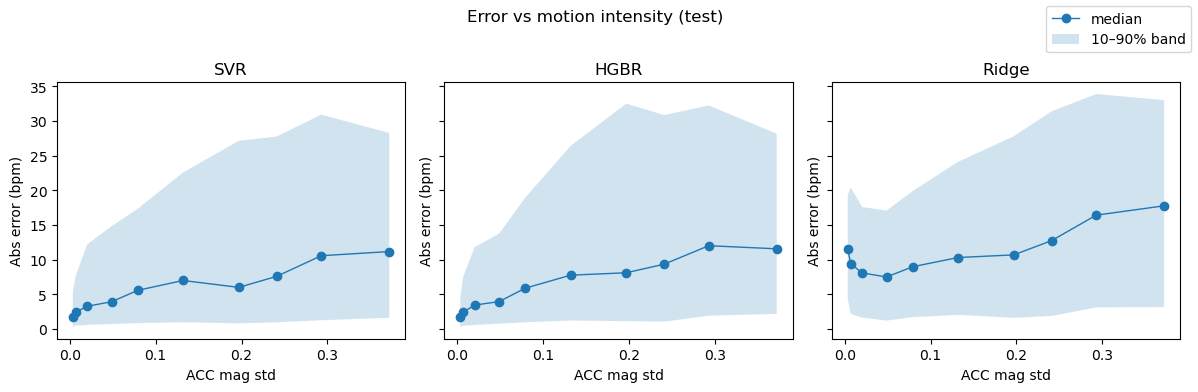

In [25]:
err_df = X_feat_test.copy()
for m in models_order:
    err_df[f"abs_err_{m}"] = np.abs(pred_df[f"y_pred_{m}"] - pred_df["y_true"])

n_bins = 10
err_df["motion_bin"] = pd.qcut(err_df["acc_mag_std"], q=n_bins, duplicates="drop")

summaries = {}
for m in models_order:
    s = (
        err_df.groupby("motion_bin", observed=False)[f"abs_err_{m}"]
        .agg(
            motion_std_median=lambda x: float(np.median(err_df.loc[x.index, "acc_mag_std"])),
            p10=lambda x: float(np.quantile(x, 0.10)),
            p50="median",
            p90=lambda x: float(np.quantile(x, 0.90)),
        )
        .reset_index(drop=True)
        .sort_values("motion_std_median")
    )
    summaries[m] = s

fig, axes = plt.subplots(1, 3, figsize=(12, 3.8), sharex=True, sharey=True)

line_handle = None
band_handle = None

for ax, m in zip(axes, models_order):
    s = summaries[m]
    (line_handle,) = ax.plot(s["motion_std_median"], s["p50"], marker="o", lw=1)
    band_handle = ax.fill_between(s["motion_std_median"], s["p10"], s["p90"], alpha=0.2)

    ax.set_title(m)
    ax.set_xlabel("ACC mag std")
    ax.set_ylabel("Abs error (bpm)")

fig.suptitle("Error vs motion intensity (test)", y=1.02)
fig.legend([line_handle, band_handle], ["median", "10–90% band"], ncol=1)
plt.tight_layout()
plt.show()


All three models show a clear increase in error as motion intensity rises, confirming the expected impact of motion artefacts on wrist PPG–based HR estimation.

Across the full motion range, **SVR** maintains the lowest median error and a relatively tighter error band, indicating better robustness to motion. **HGBR** follows a similar trend but with consistently higher median errors and a wider upper tail under high motion. **Ridge** exhibits the strongest degradation, with higher errors even at low motion and the widest spread overall, reflecting its limited capacity to model nonlinear motion effects.

These results reinforce that **nonlinear models handle motion-related variability more effectively**, but no model is fully immune to high-motion conditions.